Aim: initial size = 10, find setting AL is superior than IID, use default lr
<br> 
Try: (1) n = 1, mini-batches

In [6]:
import numpy as np
import torch
from torch import nn, distributions
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets
from dataclasses import dataclass

In [7]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=ToTensor())
mnist_test  = datasets.MNIST("../data", train=False,download=True, transform=ToTensor())
traindataloader = DataLoader(mnist_train, shuffle=True, batch_size=60000)
testdataloader  = DataLoader(mnist_test , shuffle=True, batch_size=10000)
X_train, y_train = next(iter(traindataloader))
X_test , y_test  = next(iter(testdataloader))

X_train = X_train.reshape(60000, -1)
X_test = X_test.reshape(10000, -1)

device = "cuda" if torch.cuda.is_available() else "cpu"


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [25]:
# sepeate train data into (1) initial, (2) pool
initial_idx = np.array([],dtype=int)
for i in range(10):
    idx = np.random.choice(np.where(y_train==i)[0], size=2, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [ ]:
X_pool.shape

torch.Size([59990, 784])

In [ ]:
# BALD Acquisition function (incomplete sampling in paper)
def bald(model_A, model_S1, model_S2, X, n_instances, T = 100):
  
    random_subset = np.random.choice(range(len(X)), size=len(X), replace=False)
    with torch.no_grad():
        x = X[random_subset].to(device)
        outputs = np.stack([torch.exp(model_A(x)).detach().cpu().numpy() for t in range(T)])

    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0) 
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]

    score_A = acquisition[query_idx]
    
    #---------------- score for successors:
    with torch.no_grad():
        output_S1 = np.stack([torch.exp(model_S1(X[query_idx].to(device))).detach().cpu().numpy() for t in range(T)])
        output_S2 = np.stack([torch.exp(model_S2(X[query_idx].to(device))).detach().cpu().numpy() for t in range(T)])

    pc = output_S1.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S1 * np.log(output_S1 + 1e-10), axis=-1), axis=0) 
    score_S1 = H - E_H

    pc = output_S2.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S2 * np.log(output_S2 + 1e-10), axis=-1), axis=0) 
    score_S2 = H - E_H

    return (query_idx, score_A, score_S1, score_S2) 

In [9]:
# BALD Acquisition function (in use)
def bald(model_A, model_S1, model_S2, X, n_instances, T = 100):
    with torch.no_grad():
        x = X.to(device)
        outputs = np.stack([torch.exp(model_A(x, eval = True)).detach().cpu().numpy() for t in range(T)])

    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0) 
    acquisition = H - E_H
    query_idx = (-acquisition).argsort()[:n_instances]

    score_A = acquisition[query_idx]
    
    #---------------- score for successors:
    with torch.no_grad():
        output_S1 = np.stack([torch.exp(model_S1(X[query_idx].to(device), eval = True)).detach().cpu().numpy() for t in range(T)])
        output_S2 = np.stack([torch.exp(model_S2(X[query_idx].to(device), eval = True)).detach().cpu().numpy() for t in range(T)])

    pc = output_S1.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S1 * np.log(output_S1 + 1e-10), axis=-1), axis=0) 
    score_S1 = H - E_H

    pc = output_S2.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S2 * np.log(output_S2 + 1e-10), axis=-1), axis=0) 
    score_S2 = H - E_H

    return (query_idx, score_A, score_S1, score_S2) 

In [10]:
# IID acquistion:
def iid_acq(model_A, model_S1, model_S2, X, n_instances, T = 100):

    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    with torch.no_grad():
        x = X[query_idx].to(device)
        outputs = np.stack([torch.exp(model_A(x, eval = True)).detach().cpu().numpy() for t in range(T)])
        output_S1 = np.stack([torch.exp(model_S1(x, eval = True)).detach().cpu().numpy() for t in range(T)])
        output_S2 = np.stack([torch.exp(model_S2(x, eval = True)).detach().cpu().numpy() for t in range(T)])

    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0) 
    score_A = H - E_H
    
    #---------------- score for the other 2 models:
    pc = output_S1.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S1 * np.log(output_S1 + 1e-10), axis=-1), axis=0) 
    score_S1 = H - E_H

    pc = output_S2.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S2 * np.log(output_S2 + 1e-10), axis=-1), axis=0) 
    score_S2 = H - E_H

    return (query_idx, score_A, score_S1, score_S2) 

In [18]:
def active_learning_procedure(X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              n_queries=100, 
                              n_instances=1,
                              sample_strategy = 'bald',
                              Model_A = 1,
                              Model_S1 = 2,
                              Model_S2 = 3):

    pool_idx = list()
    x_train_sample = X_initial
    y_train_sample = y_initial
    train_loader = DataLoader(list(zip(x_train_sample,  y_train_sample)), 
                      shuffle=True, batch_size = 10)

    valid_idx = np.random.randint(0, len(y_pool), len(x_train_sample))
    x_valid = X_pool[valid_idx]
    y_valid = y_pool[valid_idx]

    valid_loader = DataLoader(list(zip(x_valid,  y_valid)), 
                      shuffle=False, batch_size = len(x_valid))

    #----- Model A --------------------------
    if (Model_A==1):
        A = Model1(784, 10, n_batch = len(train_loader)).to(device)
    elif (Model_A ==2 ):
        A = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
    elif (Model_A == 3):
        A = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
    else:
        print('Invalid option for Model_A')
        return
    A.reset_bs()
    optim0 = torch.optim.Adam(A.parameters(), lr=0.001)
    _, _, acc = train(A, optim0, 1000, train_loader, valid_loader, X_test, y_test, verbose = False)
    acquisition_hist  = [acc]


    #----- Model S --------------------------
    if (Model_S1 == 1):
        S1 = Model1(784, 10, n_batch = len(train_loader)).to(device)
    elif (Model_S1 ==2):
        S1 = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
    else:
        print('Invalid option for Model_S1')
        return
    S1.reset_bs()
    optim1 = torch.optim.Adam(S1.parameters(), lr=0.001)
    _, _, acc = train(S1, optim1, 1000, train_loader, valid_loader, X_test, y_test, verbose = False)
    successor1_hist = [acc]

    if (Model_S2 == 1):
        S2 = Model1(784, 10, n_batch = len(train_loader)).to(device)
    elif (Model_S2 ==3):
        S2 = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
    else:
        print('Invalid option for Model_A')
        return
    S2.reset_bs()  
    optim2 = torch.optim.Adam(S2.parameters(), lr=0.001)
    _, _, acc = train(S2, optim2, 1000,  train_loader, valid_loader, X_test, y_test, verbose = False)
    successor2_hist = [acc]

    scores = list()

    for index in range(n_queries):
        # for incomplete sampling (paper):
        #query_idx = np.concatenate([bald(A, X_pool) for n in range(n_instances)])

        # for complete set sampling:
        if (sample_strategy  == 'bald'):
            query_idx, score_A, score_S1, score_S2 = bald(A, S1, S2, X_pool, n_instances)
        elif (sample_strategy == 'iid'):
            query_idx, score_A, score_S1, score_S2 = iid_acq(A, S1, S2, X_pool, n_instances)
        else:
            print('Unexpected sampling strategy')
            break
        
        # record scores:
        scores.append(np.vstack((score_A, score_S1, score_S2)))

        x_train_sample = torch.vstack((x_train_sample, X_pool[query_idx]))
        y_train_sample = torch.cat((y_train_sample,y_pool[query_idx]))
        train_loader = DataLoader(list(zip(x_train_sample,  y_train_sample)), 
                      shuffle=True, batch_size = 10)

        valid_idx = np.random.randint(0, len(y_pool), len(x_train_sample))
        x_valid = X_pool[valid_idx]
        y_valid = y_pool[valid_idx]
        valid_loader = DataLoader(list(zip(x_valid,  y_valid)), 
                      shuffle=False, batch_size = len(x_valid))

        # model A:
        if (Model_A==1):
            A = Model1(784, 10, n_batch = len(train_loader)).to(device)
        elif (Model_A ==2 ):
            A = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
        elif (Model_A == 3):
            A = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
        else:
            print('Invalid option for Model_A')
            return
        A.reset_bs()
        optim0 = torch.optim.Adam(A.parameters(), lr=0.001)
        _, _, acc = train(A, optim0, 1000, train_loader, valid_loader, X_test, y_test, verbose = False)
        acquisition_hist.append(acc)

        # model S:
        if (Model_S1 == 1):
            S1 = Model1(784, 10, n_batch = len(train_loader)).to(device)
        elif (Model_S1 ==2):
            S1 = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
        else:
            print('Invalid option for Model_S1')
            return
        S1.reset_bs()
        optim1 = torch.optim.Adam(S1.parameters(), lr=0.001)
        _, _, acc = train(S1, optim1, 1000,  train_loader, valid_loader, X_test, y_test, verbose = False)
        successor1_hist.append(acc)

        if (Model_S2 == 1):
            S2 = Model1(784, 10, n_batch = len(train_loader)).to(device)
        elif (Model_S2 ==3):
            S2 = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
        else:
            print('Invalid option for Model_A')
            return  
        S2.reset_bs()
        optim2 = torch.optim.Adam(S2.parameters(), lr=0.001)
        _, _, acc = train(S2, optim2, 1000, train_loader, valid_loader, X_test, y_test, verbose = False)
        successor2_hist.append(acc)

        
        # delete queried data from pool:
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        print('Query {n}: {acc:0.4f}(Model A)    |     {acc_s1:0.4f}(Model S1) - {acc_s2:0.4f}(Model S2) '.format(n=index + 1, 
                                                                                                                  acc=acquisition_hist[-1], 
                                                                                                                  acc_s1 = successor1_hist[-1], 
                                                                                                                  acc_s2 = successor2_hist[-1]))     
        pool_idx.append(query_idx)
    return(acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx)

In [24]:
class LinearVariational(nn.Module):
    def __init__(self, in_features, out_features, loss_accumulator, batch_num, n_batch, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.include_bias = bias        
        self.loss_accumulator = loss_accumulator
        self.n_batch = n_batch
        self.batch_num = batch_num
        
        if getattr(loss_accumulator, 'accumulated_kl_div', None) is None:
            loss_accumulator.accumulated_kl_div = 0
        if getattr(batch_num, 'accumulated_bs', None) is None:
            batch_num.accumulated_bs = 0

        self.w_mu = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=0, std=0.001)
        )
        # proxy for variance
        # log(1 + exp(ρ))◦ eps
        self.w_p = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=-2.5, std=0.001)
        )
        if self.include_bias:
            self.b_mu = nn.Parameter(
                torch.zeros(out_features)
            )
            self.b_p = nn.Parameter(
                torch.zeros(out_features)
            )
        
    def reparameterize(self, mu, p):
        sigma = torch.log(1 + torch.exp(p)) 
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)
    
    def kl_divergence(self, z, mu_theta, p_theta, batch_num, prior_sd=1):
        log_prior = distributions.Normal(0, prior_sd).log_prob(z) 
        log_p_q = distributions.Normal(mu_theta, torch.log(1 + torch.exp(p_theta))).log_prob(z) 
        weights =  np.power(2,self.n_batch - batch_num) /  (np.power(2,self.n_batch)-1) 

        #print('batch_num {}: weights {}'.format(batch_num, weights))
        return (log_p_q - log_prior).mean() * weights

    def forward(self, x):
        w = self.reparameterize(self.w_mu, self.w_p)
        
        if self.include_bias:
            b = self.reparameterize(self.b_mu, self.b_p)
        else:
            b = 0
            
        z = x @ w + b
        
        if (self.batch_num.clip == False):
            self.batch_num.accumulated_bs += 1
        self.loss_accumulator.accumulated_kl_div += self.kl_divergence(w, 
                                                             self.w_mu,
                                                             self.w_p,
                                                             self.batch_num.accumulated_bs
                                                             )
        if self.include_bias:
            self.loss_accumulator.accumulated_kl_div += self.kl_divergence(b, 
                                                                 self.b_mu, 
                                                                 self.b_p,
                                                                 self.batch_num.accumulated_bs
                                                                 )
        return z


@dataclass
class KL:
    accumulated_kl_div = 0
class BS:
    accumulated_bs = 0
    clip = False

def det_loss(y, y_pred, model):
    reconstruction_error = F.nll_loss(y_pred, y,reduction="mean")
    kl = model.accumulated_kl_div
    model.reset_kl_div()
    #model.reset_bs()
    #print('rec: {} | kl: {}'.format(reconstruction_error, kl))
    return reconstruction_error + kl



In [16]:
class Model1(nn.Module):
    def __init__(self, in_size, out_size, n_batch):
        super().__init__()
        self.kl_loss = KL
        self.bs_num = BS

        self.var = LinearVariational(in_size, out_size, self.kl_loss, self.bs_num, n_batch)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim = 1)
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, out_size, self.kl_loss, self.bs_num, n_batch),
            nn.LogSoftmax(dim = 1)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0

    def accumulated_bs(self):
        return self.bs_num.accumulated_bs
    
    def reset_bs(self):
        self.bs_num.accumulated_bs = 0
    
    def clip_bs(self, clip = True):
        self.bs_num.clip = clip
    
    def set_bs(self, val):
        self.bs_num.accumulated_bs = val
            
    def forward(self, x, eval = False):
        if eval:
            Model1.set_bs(self, val = 1)
            Model1.clip_bs(self, clip = True)
        else:
            Model1.clip_bs(self, clip = False)
        out = self.var(x)
        out = self.log_softmax(out)
        return out

class Model2(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batch):
        super().__init__()
        self.kl_loss = KL
        self.bs_num = BS
        
        self.var1 = LinearVariational(in_size, hidden_size, self.kl_loss, self.bs_num, n_batch)

        self.var2 = LinearVariational(hidden_size, out_size, self.kl_loss, self.bs_num, n_batch)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim = 1)


    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0

    def accumulated_bs(self):
        return self.bs_num.accumulated_bs
    
    def reset_bs(self):
        self.bs_num.accumulated_bs = 0

    def clip_bs(self, clip = True):
        self.bs_num.clip = clip
    
    def set_bs(self, val):
        self.bs_num.accumulated_bs = val
            
    def forward(self, x, eval = False):
        if eval:
            Model2.set_bs(self, val = 1)
            Model2.clip_bs(self, clip = True)
        else:
            Model2.clip_bs(self, clip = False)
        out = self.var1(x)
        out = self.relu(out)

        Model2.clip_bs(self)

        out = self.var2(out)
        out = self.log_softmax(out)


        return out

class Model3(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batch):
        super().__init__()
        self.kl_loss = KL
        self.bs_num = BS

        self.var1 = LinearVariational(in_size, hidden_size[0], self.kl_loss, self.bs_num, n_batch)
        self.var2 = LinearVariational(hidden_size[0], hidden_size[1], self.kl_loss, self.bs_num, n_batch)
        self.var3 = LinearVariational(hidden_size[1], out_size, self.kl_loss, self.bs_num, n_batch)

        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim = 1)

    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0

    def accumulated_bs(self):
        return self.bs_num.accumulated_bs
    
    def reset_bs(self):
        self.bs_num.accumulated_bs = 0

    def clip_bs(self, clip = True):
        self.bs_num.clip = clip

    def set_bs(self, val):
        self.bs_num.accumulated_bs = val
            
    def forward(self, x, eval = False):
        if eval:
            Model3.set_bs(self, val = 1)
            Model3.clip_bs(self, clip = True)
        else:
            Model3.clip_bs(self, clip = False)
        out = self.var1(x)
        out = self.relu(out)

        Model3.clip_bs(self)
        out = self.var2(out)
        out = self.relu(out)

        out = self.var3(out)
        out = self.log_softmax(out)
        return out

In [23]:
# Train
def train(model, optimizer, num_epoch,
          train_loader, valid_loader, 
          X_test, y_test,
          verbose = False):
    train_ls = list()
    valid_ls = list()
    test_acc = 0

    for epoch in range(num_epoch):
        ls = 0
        num_correct = 0
        data_num = 0

        model.train()
        for batch_num, (x, y) in enumerate(train_loader):
            #print('in train : batch_num{}'.format(batch_num))

            x = x.to(device)
            y = y.to(device)

            # forward:
            y_pred = model(x, eval = False)
            loss = det_loss(y, y_pred, model)
            ls += loss.item()

            # backward:
            optimizer.zero_grad() # remove grad from forward prop
            loss.backward()

            # update gradient:
            optimizer.step()

            # accuracy:
            #_, pred = torch.max(y_pred,1)
            #num_correct += (pred == y).sum().item()

            data_num += len(y)
        model.reset_bs()

        ls = ls/data_num
        #print('valid:')
        val_ls = eval_ls(model, valid_loader)
        weights = np.power(2, len(train_loader)-1) / (np.power(2, len(train_loader)) - 1 )
        #weights = 1

        val_ls = val_ls/weights
        model.reset_bs()
        if verbose:
            print(epoch+1)
            print(f'\tLoss: {ls:.4f}(train)\t|\tLoss: {val_ls:.4f}(valid)')
        train_ls.append(ls)
        valid_ls.append(val_ls)

        # access early stopping:
        trigger = (np.array(train_ls[epoch-50:]) < np.array(valid_ls[epoch-50:])).sum()/50
        if (trigger > 0.5):
            if verbose:
                print('Epoch {} : Early Stopping - past 50 epochs half val_ls > train_ls'.format(epoch))
            test_acc = eval_acc(model, X_test, y_test)
            break
        
        if (epoch == num_epoch-1):
            test_acc = eval_acc(model, X_test, y_test)
        

    return(train_ls, valid_ls, test_acc)


def eval_ls(model, loader):
    ls = 0
    data_num = 0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x, eval = True)
            loss = det_loss(y, y_pred, model)
            ls += loss.item()

            data_num += len(y)


    model.train()
    return ls/data_num

def eval_acc(model, test_x, test_y):

    y_sample = np.stack([torch.exp(model(test_x.to(device), eval = True)).detach().cpu().numpy() for t in range(100)])

    y_pred = y_sample.mean(axis = 0).argmax(axis = 1)

    #y_sample = model(test_x.to(device)).detach().cpu().numpy()
    #y_pred = y_sample.argmax(axis = 1)
    acc = np.equal(y_pred, test_y).sum().item()/len(test_y)
    return acc


In [ ]:
train_loader = DataLoader(list(zip(X_initial,  y_initial)), 
                      shuffle=True, batch_size = 10)
valid_loader = DataLoader(list(zip(X_pool[:1000],  y_pool[:1000])), 
                      shuffle=False, batch_size = 1000)

In [ ]:
train_x = np.vstack((X_initial, X_train[:50]))
train_y = np.hstack((y_initial, y_train[:50]))


In [ ]:
m = Model3(784, [392, 196], 10, n_batch = 6).to(device)
#m = Model2(784, 392, 10, n_batch = 6).to(device)
#m = Model1(784, 10, n_batch = 6).to(device)
optim = torch.optim.Adam(m.parameters(), lr=0.001)
m.reset_bs()

In [ ]:
train_ls, valid_ls, test_acc, y_sample = train(m, optim, 1, 
                          train_x, train_y, 
                          X_pool[:60], y_pool[:60],
                          X_test, y_test,
                          verbose = True)

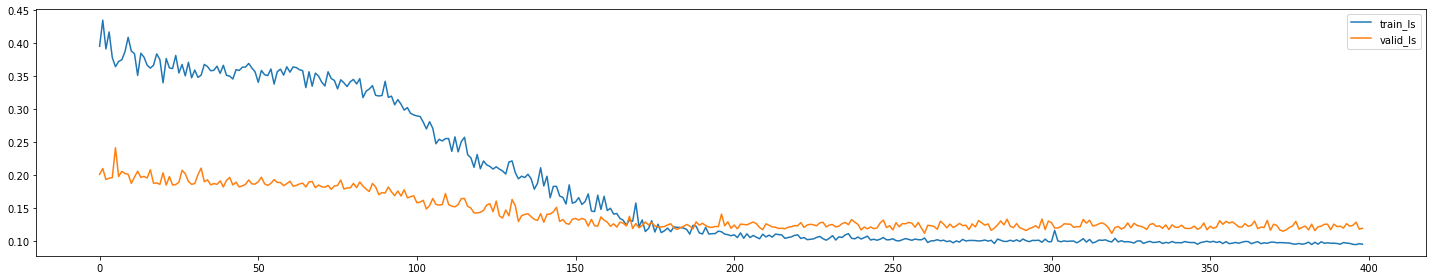

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize = (20,4))

epoch = 399
axs.plot(range(epoch), train_ls[1:], label = 'train_ls')
axs.plot(range(epoch), valid_ls[1:], label = 'valid_ls')
axs.legend()



In [26]:
# A1 BALD
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 1,
                                                                                Model_A = 1, Model_S1 = 2, Model_S2 = 3)
with open('res_bald_A1.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_bald_A1.npy')


Query 1: 0.5330(Model A)    |     0.4796(Model S1) - 0.3289(Model S2) 
Query 2: 0.5468(Model A)    |     0.5067(Model S1) - 0.4025(Model S2) 
Query 3: 0.5593(Model A)    |     0.5118(Model S1) - 0.3622(Model S2) 
Query 4: 0.5186(Model A)    |     0.4981(Model S1) - 0.2997(Model S2) 
Query 5: 0.5076(Model A)    |     0.4708(Model S1) - 0.3088(Model S2) 
Query 6: 0.5218(Model A)    |     0.4707(Model S1) - 0.3826(Model S2) 
Query 7: 0.5240(Model A)    |     0.4227(Model S1) - 0.4455(Model S2) 
Query 8: 0.5249(Model A)    |     0.4539(Model S1) - 0.2516(Model S2) 
Query 9: 0.5506(Model A)    |     0.5127(Model S1) - 0.1987(Model S2) 
Query 10: 0.5521(Model A)    |     0.4221(Model S1) - 0.2747(Model S2) 
Query 11: 0.5519(Model A)    |     0.5349(Model S1) - 0.3154(Model S2) 
Query 12: 0.5625(Model A)    |     0.5057(Model S1) - 0.3258(Model S2) 
Query 13: 0.5479(Model A)    |     0.5211(Model S1) - 0.4613(Model S2) 
Query 14: 0.5384(Model A)    |     0.4711(Model S1) - 0.4050(Model S2) 
Q

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#iid
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 1,
                                                                                sample_strategy = 'iid',
                                                                                Model_A = 1, Model_S1 = 2, Model_S2 = 3)
with open('res_iid_A1.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_iid_A1.npy')

Query 1: 0.5417(Model A)    |     0.4696(Model S1) - 0.3969(Model S2) 
Query 2: 0.5281(Model A)    |     0.4877(Model S1) - 0.3849(Model S2) 
Query 3: 0.5093(Model A)    |     0.4501(Model S1) - 0.4448(Model S2) 
Query 4: 0.5256(Model A)    |     0.4857(Model S1) - 0.3224(Model S2) 
Query 5: 0.5227(Model A)    |     0.5012(Model S1) - 0.4213(Model S2) 
Query 6: 0.5267(Model A)    |     0.5256(Model S1) - 0.3977(Model S2) 
Query 7: 0.5448(Model A)    |     0.5237(Model S1) - 0.4046(Model S2) 
Query 8: 0.5628(Model A)    |     0.5394(Model S1) - 0.4488(Model S2) 
Query 9: 0.5579(Model A)    |     0.5217(Model S1) - 0.4467(Model S2) 
Query 10: 0.5458(Model A)    |     0.5212(Model S1) - 0.4640(Model S2) 
Query 11: 0.5621(Model A)    |     0.5537(Model S1) - 0.4849(Model S2) 
Query 12: 0.5637(Model A)    |     0.5311(Model S1) - 0.4796(Model S2) 
Query 13: 0.5762(Model A)    |     0.5527(Model S1) - 0.4667(Model S2) 
Query 14: 0.5799(Model A)    |     0.5228(Model S1) - 0.4275(Model S2) 
Q

In [ ]:
# A2 BALD
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 1,
                                                                                Model_A = 2, Model_S1 = 1, Model_S2 = 3)
with open('res_bald_A2.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_bald_A2.npy')

In [ ]:
# A3 BALD
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 1,
                                                                                Model_A = 3, Model_S1 = 2, Model_S2 = 1)
with open('res_bald_A3.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_bald_A3.npy')


In [ ]:
# check stopping creterion for bald:
train_x = X_initial
train_y = y_initial

for query_idx in pool_idx[:2]:
  train_x = np.vstack((train_x, X_pool[query_idx]))
  train_y = np.hstack((train_y, y_pool[query_idx]))

  X_pool = np.delete(X_pool, query_idx, axis=0)
  y_pool = np.delete(y_pool, query_idx, axis=0)

  valid_idx = np.random.randint(0, len(y_pool), 1000)
  x_valid = X_pool[valid_idx]
  y_valid = y_pool[valid_idx]

  m = Model1(784, 10, data_num = len(train_x)).to(device)
  optim = torch.optim.Adam(m.parameters(), lr=0.001)
  train_ls, valid_ls = train(m, optim, 1000, 
                              train_x, train_y, 
                              x_valid, y_valid,
                              verbose = False)
  y_sample = np.stack([torch.exp(m(X_test.to(device))).detach().cpu().numpy() for t in range(100)])
  y_pred = y_sample.mean(axis = 0).argmax(axis = 1)
  acc = np.equal(y_pred, y_test).sum().item()/len(y_test)
  print('data size {}:  acc {}'.format(len(train_x), acc))

data size 15:  acc 0.4555
data size 20:  acc 0.4485
